#### We are going to make a parallel workflow 

<p align="center">
  <img src="/Users/umesh/Desktop/LangGraph-AI-Agents-/images/parallelization.png" width="500"/>
</p>

For merging the scores from all 3 methods parallely we need to use REDUCER function 

In [4]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated

In [2]:
# we'll use LLM from ollama
from langchain_ollama import ChatOllama 

llm = ChatOllama(
    model='llama3.2',
    verbose=True,
    temperature=0.2
)

llm.invoke("How are you?")

AIMessage(content="I'm just a language model, so I don't have feelings or emotions like humans do. However, I'm functioning properly and ready to assist you with any questions or tasks you may have! How can I help you today?", additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2026-01-06T16:47:05.756288Z', 'done': True, 'done_reason': 'stop', 'total_duration': 13067759834, 'load_duration': 150894042, 'prompt_eval_count': 29, 'prompt_eval_duration': 9635674458, 'eval_count': 47, 'eval_duration': 3277667125, 'logprobs': None, 'model_name': 'llama3.2', 'model_provider': 'ollama'}, id='lc_run--019b9434-4708-7943-99d6-7cb84ef6c7dc-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 29, 'output_tokens': 47, 'total_tokens': 76})

In [3]:
class AnalyzerState(TypedDict):
    """
    State for document analyzer workflow which includes scores and feedback from all 3 methods
    """
    essay: str 
    cot_score: float 
    doa_score: float 
    language_score: float
    cot_feedback: str 
    doa_feedback: str 
    language_feedback: str 
    final_score: float 
    final_feedback: str
    

In [6]:
# class to validate structured output out of LLM
from pydantic import BaseModel, Field 

class ScoreFeedback(BaseModel):
    score: Annotated[int, Field(description="Score in range of 0 to 10.")]
    feedback: Annotated[str, Field(description="Feeback about the document.")]

# configuring llm for structured output 
llm_str = llm.with_structured_output(ScoreFeedback)

In [27]:
from langchain_core.prompts import PromptTemplate 

def cot_analyzer(state: AnalyzerState):
    """
    COT Analyzer - gives you a score and feedback 
    """
    template = """ 
                You are intelligent evaluator which evaluate essays and documents on the basis of clarity of their thought. Generate a score in range of 0 to 10. 
                And also generate a feedback for document.
                <document>{document}</document>
               """
    
    prompt = PromptTemplate(
        template=template,
        input_variables=['document']
    )

    chain = prompt | llm_str 

    response = chain.invoke({'document' : state['essay']})
    return {'cot_score' : response.score, 'cot_feedback' : response.feedback}

def doa_analyzer(state: AnalyzerState):
    """
    DOA Analyzer - gives you a score and feedback 
    """
    template = """ 
                You are intelligent evaluator which evaluate essays and documents on the basis of Depth of Analysis it carries. Generate a score in range of 0 to 10. 
                And also generate a feedback for document.
                <document>{document}</document>
               """
    
    prompt = PromptTemplate(
        template=template,
        input_variables=['document']
    )

    chain = prompt | llm_str 

    response = chain.invoke({'document' : state['essay']})
    return {'doa_score' : response.score, 'doa_feedback' : response.feedback}

def language_analyzer(state: AnalyzerState):
    """
    Language Analyzer - gives you a score and feedback 
    """
    template = """ 
                You are intelligent evaluator which evaluate essays and documents on the basis of language. Generate a score in range of 0 to 10. 
                And also generate a feedback for document.
                <document>{document}</document>
               """
    
    prompt = PromptTemplate(
        template=template,
        input_variables=['document']
    )

    chain = prompt | llm_str 

    response = chain.invoke({'document' : state['essay']})
    return {'language_score' : response.score, 'language_feedback' : response.feedback}


def final_analyzer(state: AnalyzerState):
    """
    Final Analyzer - gives you a score and feedback 
    """
    template = """ 
                You need to combine the feedback for document from the 3 evalautors :
                COT_evalauator, DOA_evaluator, and language_evaluator 
                And also generate a feedback for document.
                <document>{document}</document>
                <cot_feedback>{cot_feedback}</cot_feedback>
                <doa_feedback>{doa_feedback}</doa_feedback>
                <language_feedback>{language_feedback}</language_feedback>
               """
    
    prompt = PromptTemplate(
        template=template,
        input_variables=['document', 'cot_feedback', 'doa_feedback', 'language_feedback']
    )

    chain = prompt | llm

    response = chain.invoke({'document' : state['essay'], 'cot_feedback': state['cot_feedback'], 'doa_feedback' : state['doa_feedback'], 'language_feedback': state['language_feedback']})

    final_score = int((state['cot_score'] + state['doa_score'] + state['language_score'])/3)
    
    return {'final_score' : final_score, 'final_feedback' : response.content}


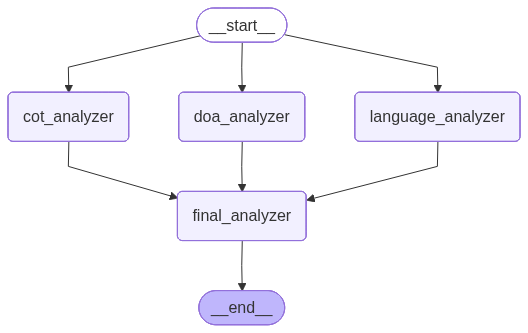

In [28]:
graph = StateGraph(AnalyzerState)

# add nodes 
graph.add_node('cot_analyzer', cot_analyzer)
graph.add_node('doa_analyzer', doa_analyzer)
graph.add_node('language_analyzer', language_analyzer)
graph.add_node('final_analyzer', final_analyzer)

# add edges 
graph.add_edge(START, 'cot_analyzer')
graph.add_edge(START, 'doa_analyzer')
graph.add_edge(START, 'language_analyzer')

graph.add_edge('cot_analyzer', 'final_analyzer')
graph.add_edge('doa_analyzer', 'final_analyzer')
graph.add_edge('language_analyzer', 'final_analyzer')

graph.add_edge('final_analyzer', END)

# compile graph 
document_analyzer = graph.compile()

# display graph
from IPython.display import Image 
Image(document_analyzer.get_graph().draw_mermaid_png())

In [29]:
input_state = {'essay' : """
    India in the Age of AI
As the world enters a transformative era defined by artificial intelligence (AI), India stands at a critical juncture — one where it can either emerge as a global leader in AI innovation or risk falling behind in the technology race. The age of AI brings with it immense promise as well as unprecedented challenges, and how India navigates this landscape will shape its socio-economic and geopolitical future.

India's strengths in the AI domain are rooted in its vast pool of skilled engineers, a thriving IT industry, and a growing startup ecosystem. With over 5 million STEM graduates annually and a burgeoning base of AI researchers, India possesses the intellectual capital required to build cutting-edge AI systems. Institutions like IITs, IIITs, and IISc have begun fostering AI research, while private players such as TCS, Infosys, and Wipro are integrating AI into their global services. In 2020, the government launched the National AI Strategy (AI for All) with a focus on inclusive growth, aiming to leverage AI in healthcare, agriculture, education, and smart mobility.

One of the most promising applications of AI in India lies in agriculture, where predictive analytics can guide farmers on optimal sowing times, weather forecasts, and pest control. In healthcare, AI-powered diagnostics can help address India’s doctor-patient ratio crisis, particularly in rural areas. Educational platforms are increasingly using AI to personalize learning paths, while smart governance tools are helping improve public service delivery and fraud detection.

However, the path to AI-led growth is riddled with challenges. Chief among them is the digital divide. While metropolitan cities may embrace AI-driven solutions, rural India continues to struggle with basic internet access and digital literacy. The risk of job displacement due to automation also looms large, especially for low-skilled workers. Without effective skilling and re-skilling programs, AI could exacerbate existing socio-economic inequalities.

Another pressing concern is data privacy and ethics. As AI systems rely heavily on vast datasets, ensuring that personal data is used transparently and responsibly becomes vital. India is still shaping its data protection laws, and in the absence of a strong regulatory framework, AI systems may risk misuse or bias.

To harness AI responsibly, India must adopt a multi-stakeholder approach involving the government, academia, industry, and civil society. Policies should promote open datasets, encourage responsible innovation, and ensure ethical AI practices. There is also a need for international collaboration, particularly with countries leading in AI research, to gain strategic advantage and ensure interoperability in global systems.

India’s demographic dividend, when paired with responsible AI adoption, can unlock massive economic growth, improve governance, and uplift marginalized communities. But this vision will only materialize if AI is seen not merely as a tool for automation, but as an enabler of human-centered development.

In conclusion, India in the age of AI is a story in the making — one of opportunity, responsibility, and transformation. The decisions we make today will not just determine India’s AI trajectory, but also its future as an inclusive, equitable, and innovation-driven society.
"""}

In [30]:
output_state = document_analyzer.invoke(input_state)

In [31]:
from pprint import pprint

pprint(output_state)

{'cot_feedback': 'The essay provides a comprehensive overview of the potential '
                 "impact of artificial intelligence on India's socio-economic "
                 'and geopolitical landscape. The author highlights both the '
                 'benefits and challenges associated with AI adoption in '
                 'India, demonstrating a nuanced understanding of the subject '
                 'matter. However, there are moments where the writing could '
                 'be more precise and concise, particularly in the '
                 'introduction and conclusion. Additionally, some paragraphs '
                 'feel slightly disconnected from each other, which may make '
                 "it challenging for readers to follow the author's train of "
                 'thought. Nevertheless, the essay presents a compelling '
                 "vision for India's AI future and offers practical "
                 'suggestions for responsible AI adoption.',
 'cot_score': 